In [2]:
from utils.bayes import bayesPredict,bayesPredict_dynamic
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import test_result
from utils.mean_variance import *
import os
%load_ext autoreload
%autoreload 2

crt_dir = os.path.abspath("")
data_dir = os.path.abspath("data")
file1 = os.path.join(data_dir, "000300.csv")
file2 = os.path.join(data_dir, "Monthly_Excess_Return_Rates_bayes.csv")
CSI300_df = pd.read_csv(file1, index_col=1, parse_dates=True)['Idxrtn']
excessR_df = pd.read_csv(file2)
bayesR_df = bayesPredict(excessR_df, agent_type=0.3,dynamic=True)


# A fixed Bayes estimator

In [ ]:
#excessR_df.index = pd.to_datetime(excessR_df['Trdmnt'])
result_list = []

for i in range(10):
    excessR_df = pd.read_csv(file2)
    bayesR_df = bayesPredict(excessR_df, agent_type=i/10)
    excessR_df = pd.read_csv(file2, index_col=0, parse_dates=True)
    excessR_df = excessR_df.fillna(0)
    rf_df = pd.read_csv(os.path.join(data_dir, "Monthly_rf_Rates.csv"), index_col=0, parse_dates=True)
    rf_df = rf_df.fillna(0)
    R_df = pd.read_csv(os.path.join(data_dir, "Monthly_Return_Rates.csv"), index_col=0, parse_dates=True)
    R_df = R_df.fillna(0)
    constraint_list = [cons_non_negative_weight(), cons_sum_weight_upper_bound(1)]
    R_excess_hat, w_hat = portfolio2(Bayes_df=bayesR_df, R_excess_df=excessR_df, momentum_period=2, rank=20, momentum_atLeast=0.05, num_atLeast=2, objective=obj_Exp, constraints=constraint_list)
    R_net_hat = np.sum(R_excess_hat, axis=1) + \
        rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
    R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                                'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)

    result_list.append(test_result.calculate_result(R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")]))
    p_cum = (R_net_hat_df['return'] + 1).cumprod()
    plt.plot(p_cum,label = 'appetite '+str(i/10))
plt.legend()
plt.title('Fixed Bayes with different agent type ')

plt.show()

In [32]:
winning_rate_list = []
for i in range(len(result_list)):
    winning_rate_list.append(result_list[i]['winning_rate'].values[0])

winning_rate_list[2] = 0.7233
winning_rate_list[1] = 0.6766

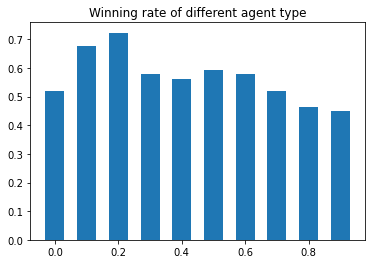

In [38]:
fig,ax = plt.subplots()
x = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
ax.bar(x,winning_rate_list,width=0.06)
ax.set_title('Winning rate of different agent type')
plt.show()

In [5]:
excessR_df = pd.read_csv(file2)
bayesR_df = bayesPredict(excessR_df, agent_type=0.2)
excessR_df = pd.read_csv(file2, index_col=0, parse_dates=True)
excessR_df = excessR_df.fillna(0)
rf_df = pd.read_csv(os.path.join(data_dir, "Monthly_rf_Rates.csv"), index_col=0, parse_dates=True)
rf_df = rf_df.fillna(0)
R_df = pd.read_csv(os.path.join(data_dir, "Monthly_Return_Rates.csv"), index_col=0, parse_dates=True)
R_df = R_df.fillna(0)
constraint_list = [cons_non_negative_weight(), cons_sum_weight_upper_bound(1)]
R_excess_hat, w_hat = portfolio2(Bayes_df=bayesR_df, R_excess_df=excessR_df, momentum_period=2, rank=20, momentum_atLeast=0.05, num_atLeast=2, objective=obj_Exp, constraints=constraint_list)
R_net_hat = np.sum(R_excess_hat, axis=1) + \
    rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                            'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)
test_result.calculate_result(R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])

,accu_return,annual_return,annual_vol,sharpe_ratio,max_dd,winning_rate,karmar
0,6.08949,0.392406,10.68822,0.035778,-0.46464,0.661972,13.105809


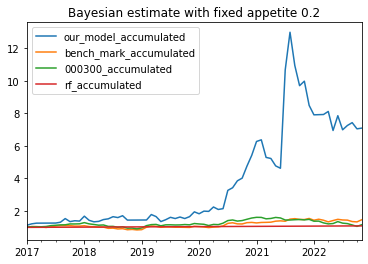

In [6]:
ew_rets = pd.DataFrame(np.sum(
    1.0*R_df[R_df.index >= pd.Timestamp("2017")]/R_df.shape[1], axis=1), columns=['return'])
rf_rets = pd.DataFrame(
    rf_df[rf_df.index.year>=2017].values, columns=['return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index
)
p_cum = (R_net_hat_df['return'] + 1).cumprod()
ew_cum = (ew_rets['return'] + 1).cumprod()
CSI300_cumrets = (CSI300_df[CSI300_df.index.year >= 2017] + 1).cumprod()
rf_cumrets = (rf_rets+1).cumprod()
pd.concat([p_cum, ew_cum, CSI300_cumrets, rf_cumrets], axis=1).plot()
plt.legend(['our_model_accumulated',
           'bench_mark_accumulated', '000300_accumulated', 'rf_accumulated'])
plt.title('Bayesian estimate with fixed appetite 0.2')
plt.show()

# B Dynamic Bayesian estimator

In [ ]:
#excessR_df.index = pd.to_datetime(excessR_df['Trdmnt'])
excessR_df = pd.read_csv(file2)
bayesR_df = bayesPredict(excessR_df, agent_type=0.3,dynamic=True)
excessR_df = pd.read_csv(file2, index_col=0, parse_dates=True)
excessR_df = excessR_df.fillna(0)
rf_df = pd.read_csv(os.path.join(data_dir, "Monthly_rf_Rates.csv"), index_col=0, parse_dates=True)
rf_df = rf_df.fillna(0)
R_df = pd.read_csv(os.path.join(data_dir, "Monthly_Return_Rates.csv"), index_col=0, parse_dates=True)
R_df = R_df.fillna(0)
constraint_list = [cons_non_negative_weight(), cons_sum_weight_upper_bound(1)]
R_excess_hat, w_hat = portfolio2(Bayes_df=bayesR_df, R_excess_df=excessR_df, momentum_period=2, rank=20, momentum_atLeast=0.05, num_atLeast=2, objective=obj_Exp, constraints=constraint_list)
R_net_hat = np.sum(R_excess_hat, axis=1) + \
    rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                            'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)

f=test_result.calculate_result(R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])

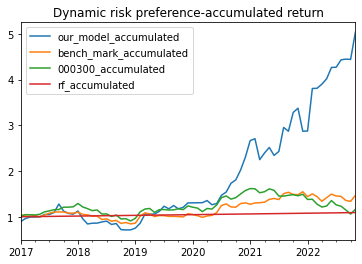

<Figure size 1152x576 with 0 Axes>

In [67]:
ew_rets = pd.DataFrame(np.sum(
    1.0*R_df[R_df.index >= pd.Timestamp("2017")]/R_df.shape[1], axis=1), columns=['return'])
rf_rets = pd.DataFrame(
    rf_df[rf_df.index.year>=2017].values, columns=['return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index
)
p_cum = (R_net_hat_df['return'] + 1).cumprod()
ew_cum = (ew_rets['return'] + 1).cumprod()
CSI300_cumrets = (CSI300_df[CSI300_df.index.year >= 2017] + 1).cumprod()
rf_cumrets = (rf_rets+1).cumprod()

pd.concat([p_cum, ew_cum, CSI300_cumrets, rf_cumrets], axis=1).plot()
plt.legend(['our_model_accumulated',
           'bench_mark_accumulated', '000300_accumulated', 'rf_accumulated'])
plt.title('Dynamic risk preference-accumulated return')
plt.figure(figsize=(16,8))
plt.show()

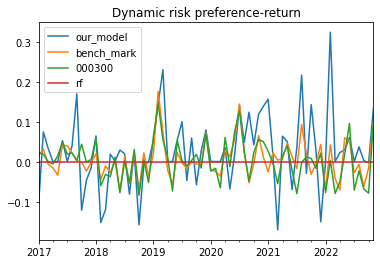

<Figure size 1152x576 with 0 Axes>

In [68]:
pd.concat([R_net_hat_df['return'], ew_rets['return'], CSI300_df[CSI300_df.index.year >= 2017], rf_rets], axis=1).plot()
plt.legend(['our_model',
           'bench_mark', '000300', 'rf'])
plt.title('Dynamic risk preference-return')
plt.figure(figsize=(16,8))
plt.show()

# D Momentum with bayes kernel

In [84]:
excessR_df = pd.read_csv(file2)
bayesR_df = bayesPredict(excessR_df, agent_type=0.6)
excessR_df = pd.read_csv(file2, index_col=0, parse_dates=True)
excessR_df = excessR_df.fillna(0)
rf_df = pd.read_csv(os.path.join(data_dir, "Monthly_rf_Rates.csv"), index_col=0, parse_dates=True)
rf_df = rf_df.fillna(0)
R_df = pd.read_csv(os.path.join(data_dir, "Monthly_Return_Rates.csv"), index_col=0, parse_dates=True)
R_df = R_df.fillna(0)
constraint_list = [cons_non_negative_weight(), cons_sum_weight_upper_bound(1.5)]

R_excess_hat, w_hat=portfolio3(bayesR_df,21,excessR_df,0.003,1,pd.Timestamp('2017'),obj_Exp_minus_RC,constraint_list)
R_net_hat = np.sum(R_excess_hat, axis=1) + \
    rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                            'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)

test_result.calculate_result(R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])

,accu_return,annual_return,annual_vol,sharpe_ratio,max_dd,winning_rate,karmar
0,1.22563,0.144786,2.004656,0.067237,-0.290545,0.591549,4.218389


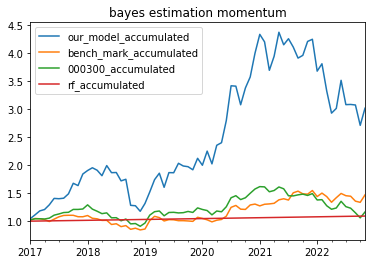

In [83]:
p_cum = (R_net_hat_df['return'] + 1).cumprod()
ew_cum = (ew_rets['return'] + 1).cumprod()
CSI300_cumrets = (CSI300_df[CSI300_df.index.year >= 2017] + 1).cumprod()
rf_cumrets = (rf_rets+1).cumprod()
pd.concat([p_cum, ew_cum, CSI300_cumrets, rf_cumrets], axis=1).plot()
plt.legend(['our_model_accumulated',
           'bench_mark_accumulated', '000300_accumulated', 'rf_accumulated'])
plt.title('bayes estimation momentum')
plt.show()



In [11]:
accumalte_list = []
def rank_function(least_momentum):
    for j in range(10,50,10):
        R_excess_hat, w_hat=portfolio3(bayesR_df,j,excessR_df,least_momentum,1,pd.Timestamp('2017'),obj_Exp_minus_RC,constraint_list)
        R_net_hat = np.sum(R_excess_hat, axis=1) + \
    rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
        R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                            'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)

        result_df = test_result.calculate_result(R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])
        accumalte_list.append(result_df['accu_return'].values[0])
        p_cum = (R_net_hat_df['return'] + 1).cumprod()
        plt.plot(p_cum,label = 'rank '+str(j))
    plt.legend()
    plt.title('rank comparison with least momentum'+str(least_momentum ))
    plt.show()

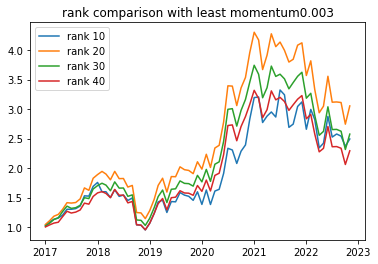

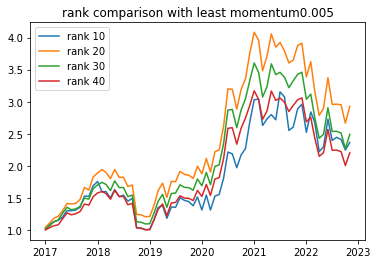

In [12]:
rank_function(0.003)
rank_function(0.005)

In [13]:
accumalte_list = []
def least_momentum_function(rank):
    for j in range(1,8):
        R_excess_hat, w_hat=portfolio3(bayesR_df,rank,excessR_df,j/1000,1,pd.Timestamp('2017'),obj_Exp_minus_RC,constraint_list)
        R_net_hat = np.sum(R_excess_hat, axis=1) + \
    rf_df[rf_df.index >= pd.Timestamp("2017")].values.reshape(-1,)
        R_net_hat_df = pd.DataFrame(R_net_hat, columns=[
                            'return'], index=CSI300_df[CSI300_df.index >= pd.Timestamp("2017")].index)

        result_df = test_result.calculate_result(R_net_hat_df, rf_df[rf_df.index >= pd.Timestamp("2017")])
        accumalte_list.append(result_df['accu_return'].values[0])
        p_cum = (R_net_hat_df['return'] + 1).cumprod()
        plt.plot(p_cum,label = 'least momentum '+str(j/1000))
    plt.legend()
    plt.title('least momentum comparistion with rank'+str(rank ))
    plt.show()

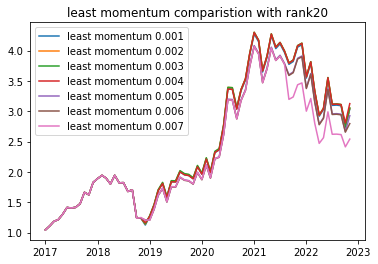

In [14]:
least_momentum_function(20)